In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

simulate_data = False

if not simulate_data:
    analysis_name = 'simulated_data_small'
    #analysis_name = 'simulated_data_large'
    #analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

    json_file = open(json_filename, 'r')
    json_dat = json.load(json_file)
    json_file.close()

    stan_dat = json_dat['stan_dat']
    #vp_base = json_dat['vp_base']

    print(stan_dat.keys())
    K = stan_dat['K'][0]
    NObs = stan_dat['N'][0]
    NG = stan_dat['NG'][0]
    #N = NObs / NG
    y_g_vec = np.array(stan_dat['y_group'])
    y_vec = np.array(stan_dat['y'])
    x_mat = np.array(stan_dat['x'])
    
    glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

    # Define a class to contain prior parameters.
    prior_par = logit_glmm.get_default_prior_params(K)
    prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

    prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

    prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
    prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])
    
    prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
    prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])
    
    # An index set to make sure jacobians match the order expected by R.
    prior_par_indices = copy.deepcopy(prior_par)
    prior_par_indices.set_name('Prior Indices')
    prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))
else:
    # Simulate data instead of loading it if you like
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    # Generate data

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)

    prior_par = logit_glmm.get_default_prior_params(K)

    glmm_par = logit_glmm.get_glmm_parameters(
        K=K, NG=NG, 
        mu_info_min=0.001, tau_alpha_min=0.001,
        tau_beta_min=0.001, beta_diag_min=0.001,
        u_info_min=0.001)


print(np.mean(y_vec))

dict_keys(['K', 'tau_prior_beta', 'beta_prior_mean', 'NG', 'y_group', 'mu_prior_mean', 'N', 'mu_prior_info', 'tau_prior_alpha', 'beta_prior_info', 'x', 'y'])
0.324


In [3]:


glmm_init = False
if glmm_init and not simulate_data:
    # Initialize with GLMM.
    # If you use this, don't forget to add the computation time to your final VB time!
    glmm_time = 0.

    glmm_fit = json_dat['glmm_fit']
    glmm_par['mu'].mean.set(glmm_fit['mu_mean'][0])
    glmm_par['mu'].info.set(1.0)

    tau_mean = 1.0 / glmm_fit['mu_sd'][0] ** 2
    tau_var = 1.0
    glmm_par['tau'].shape.set((tau_mean ** 2) / tau_var)
    glmm_par['tau'].rate.set(tau_var / tau_mean)

    glmm_par['beta'].mean.set(np.array(glmm_fit['beta_mean']))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.array(glmm_fit['u_map']))
    glmm_par['u'].info.set(np.full(NG, 1.0))

    free_par_vec = glmm_par.get_free()
else:
    glmm_time = 0.
    glmm_par['mu'].mean.set(0.0)
    glmm_par['mu'].info.set(1.0)

    glmm_par['tau'].shape.set(2.0)
    glmm_par['tau'].rate.set(2.0)

    glmm_par['beta'].mean.set(np.full(K, 0.0))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.full(NG, 0.0))
    glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [4]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = get_moment_jacobian(init_par_vec)


In [5]:

model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.001187564095016569
	Grad time: 0.006480430800002069
	Hessian vector product time: 0.014736441796412692
	Prior hess time:  0.06890082359313965


In [6]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_gh_points, gtol=1e-6, maxiter=500):
    model.set_gh_points(num_gh_points)
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [7]:
import pandas as pd
#print(glmm_par)

x_t_x = np.matmul(x_mat.transpose(), x_mat)
x_t_y = np.matmul(x_mat.transpose(), y_vec)
beta_init = np.linalg.solve(x_t_x, x_t_y)
#print(beta_init)
#plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
#print(df.sum())
u_init = np.array(df.sum()) / np.array(df.count()['y'])
#plt.figure()
print(np.min(y_g_vec))
#plt.plot(u_init[y_g_vec], y_vec, 'k.')


0


In [8]:
# Optimize.

print('Running Newton Trust Region with few draws.')
num_gh_points = 4
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_gh_points, gtol=1e-6, maxiter=500)
vb_time_opt_1 = time.time() - vb_time
#print('vb_time_opt_1: ', vb_time_opt_1)
vb_time = time.time() - vb_time

# print('Running Newton Trust Region with more draws')
# num_gh_points = 20
# # vb_time = time.time()
# opt_x = tr_optimize(opt_x, num_gh_points, gtol=1e-6, maxiter=100)
# vb_time = time.time() - vb_time

print('VB time: ', vb_time)
print('Done.')

Running Newton Trust Region with few draws.
Iter  0  value:  1034.44059918
	x_diff:  inf
Iter  5  value:  222.349417308
	x_diff:  1.42822867231
Iter  10  value:  76.7117519695
	x_diff:  0.916654154504
Iter  15  value:  69.3355009275
	x_diff:  0.159558673608
Optimization terminated successfully.
         Current function value: 69.330981
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 0
VB time:  3.5663294792175293
Done.


In [9]:

glmm_par.set_free(opt_x)
if simulate_data:
    print('Fit beta: ', glmm_par['beta'].e())
    print('True beta: ', true_beta)
    
    print('Fit mu: ', glmm_par['mu'].e())
    print('True mu: ', true_mu)
    
    print('Fit tau: ', glmm_par['tau'].e())
    print('True tau: ', true_tau)
    
    plt.plot(true_u, true_u, 'r.')
    plt.plot(true_u, glmm_par['u'].e(), 'k.')
    

In [10]:
print(vb_time_opt_1)
print(vb_time - vb_time_opt_1)


3.566304922103882
2.4557113647460938e-05


VB time:  3.5663294792175293
[ 0.72659812  1.89783076  3.31028161  4.19112418  5.2443219 ]
GLMM Parameters:
	mu:
mu_mean: [-3.58689269]
mu_info: [ 101.79848479]
	tau:
tau_shape: [ 52.99999978]
tau_rate: [ 52.06875819]
	beta:
beta_mean:
[ 0.72659812  1.89783076  3.31028161  4.19112418  5.2443219 ]
beta_info:
[[ 19.90139139   1.537584     1.79316044   1.1716148    1.44494035]
 [  1.537584    19.93884551  -0.60244701   1.59036098  -1.15202817]
 [  1.79316044  -0.60244701  14.07471897  -0.53789248  -2.55185057]
 [  1.1716148    1.59036098  -0.53789248  15.79077914  -3.45016328]
 [  1.44494035  -1.15202817  -2.55185057  -3.45016328  13.44048995]]
	u:
u_mean:
[-3.07347311 -3.57603209 -3.77950233 -4.44325575 -3.51764448 -3.88686897
 -3.69932252 -3.76567835 -2.73880961 -3.47690654 -2.7855888  -3.27113769
 -3.71875716 -3.79701444 -3.59067252 -3.06494631 -3.30427204 -4.17309857
 -3.80269617 -3.0318877  -2.58949618 -3.65957655 -3.65687996 -4.557617
 -3.24092232 -4.29173848 -3.64939983 -3.59042534

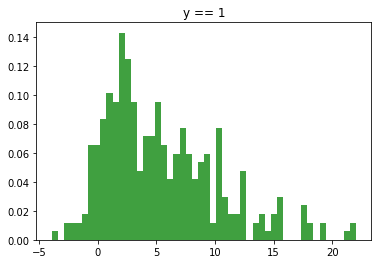

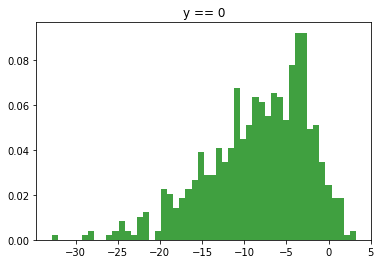

In [11]:
print('VB time: ', vb_time)

import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
#glmm_par_opt.set_free(init_par_vec)
print(glmm_par_opt['beta'].e())
print(glmm_par_opt)

#plt.plot(glmm_par_opt['u'].e(), glmm_par_opt['u'].var(), 'k.')

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)
#plt.plot(sp.special.expit(z_mean), model.y_vec, 'k.')

plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [12]:
# Get the Hessians at the number of draws used for optimization.

hess_time = time.time()
print('KL Hessian...\n')
kl_hess = objective.fun_free_hessian(opt_x)

print('Log prior Hessian...\n')
log_prior_hess = get_prior_hess(prior_par.get_vector(), opt_x)

hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print('hess_time: %f' % hess_time)

KL Hessian...

Log prior Hessian...

hess_time: 1.930953


In [13]:
moment_jac = get_moment_jacobian(opt_x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))


In [14]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                    'vb_time': vb_time, 'hess_time': hess_time, 'num_gh_points': num_gh_points, 
                    'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                    'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

    result_json = json.dumps(result_dict)
    json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)
    json_file = open(json_output_filename, 'w')
    json_file.write(result_json)
    json_file.close()
    print(json_output_filename)

    
    
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
    pickle_output = open(pickle_output_filename, 'wb')

    # TODO: save everything needed to reconstruct glmm_par, since the parameters cannot be pickled
    # due to having function pointers.
    # Unlike with JSON, numpy arrays can be pickled.
    pickle_result_dict = {  'glmm_par_dictval': glmm_par_opt.dictval(),
                            'glmm_par_vector': glmm_par_opt.get_vector(),
                            'glmm_par_free': glmm_par_opt.get_free(),
                            'run_name': run_name,
                            'vb_time': vb_time,
                            'hess_time': hess_time,
                            'num_gh_points': num_gh_points, 
                            'lrvb_cov': np.squeeze(lrvb_cov),
                            'moment_jac': np.squeeze(moment_jac),
                            'elbo_hess': np.squeeze(elbo_hess),
                            'log_prior_hess': np.squeeze(log_prior_hess) }

    # Pickle dictionary using protocol 0.
    pickle.dump(pickle_result_dict, pickle_output)
    pickle_output.close()
    
    print(pickle_output_filename)


    

/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_small_python_vb_results.json
/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_small_python_vb_results.pkl
